# 基于双均线的量化策略与回测

数据集为15分钟级别的某品种利率债数据

配置环境

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 读取数据

In [2]:
root = '/kaggle/input/bond-rate/PROJECT_TRAIN_GK.parquet'
data = pd.read_parquet(root)

In [3]:
data.head()

,平均价,最高价,最低价,开盘价,收盘价,成交量
TIME,,,,,,
2018-01-02 09:15:00,4.979000,4.979,4.979,4.9790,4.979,5
2018-01-02 09:30:00,4.979000,4.979,4.979,4.9790,4.979,3
2018-01-02 09:45:00,4.984000,4.984,4.984,4.9840,4.984,3
2018-01-02 10:00:00,4.987125,4.989,4.984,4.9865,4.984,4
2018-01-02 10:15:00,4.980875,4.984,4.979,4.9815,4.979,4


In [4]:
data.tail()

,平均价,最高价,最低价,开盘价,收盘价,成交量
TIME,,,,,,
2020-12-31 16:00:00,4.223944,4.2245,4.222833,4.2245,4.222833,3
2020-12-31 16:15:00,4.220594,4.2220,4.219500,4.2220,4.219500,4
2020-12-31 16:30:00,4.223250,4.2245,4.222000,4.2220,4.224500,2
2020-12-31 16:45:00,4.222000,4.2220,4.222000,4.2220,4.222000,1
2020-12-31 17:00:00,4.223000,4.2230,4.223000,4.2230,4.223000,1


## 生成交易策略

In [5]:
class Strategy():
    def __init__(self, data, short_window=10, long_window=30) -> None:
        self.data = data
        self.short_window = short_window
        self.long_window = long_window
        self.signal = pd.Series(index=data.index)
        self.data['price'] = data['收盘价'] # generally, using close price as the price data

    def generate_signal(self):
        self.data['short_MA'] = self.data['price'].rolling(window=self.short_window, min_periods=1).mean()
        self.data['long_MA'] = self.data['price'].rolling(window=self.long_window, min_periods=1).mean()

        # generate trading signal: 1->buy 0->hold -1->sell
        # self.signal = 0.0
        self.signal[self.short_window:] = np.where(
            self.data['short_MA'][self.short_window:] > self.data['long_MA'][self.short_window:], 1.0, 0.0
        )
        self.signal.diff().fillna(0)

        return self.signal

## 回测代码

In [6]:
strategy = Strategy(data)
signal = strategy.generate_signal()
ytm_avg = strategy.data['price']

pnl = signal * ytm_avg.diff().shift(-2)
drawdown = (pnl.cumsum().cummax() - pnl.cumsum()).max()
sharpe = pnl.mean() / (pnl.std() + 1e-10)

In [7]:
print(sharpe)
print(drawdown)
print(pnl)

0.02332845601258038
0.21517082547053912
TIME
2018-01-02 09:15:00       NaN
2018-01-02 09:30:00       NaN
2018-01-02 09:45:00       NaN
2018-01-02 10:00:00       NaN
2018-01-02 10:15:00       NaN
                        ...  
2020-12-31 16:00:00    0.0050
2020-12-31 16:15:00   -0.0025
2020-12-31 16:30:00    0.0010
2020-12-31 16:45:00       NaN
2020-12-31 17:00:00       NaN
Length: 24208, dtype: float64


## 展示图像

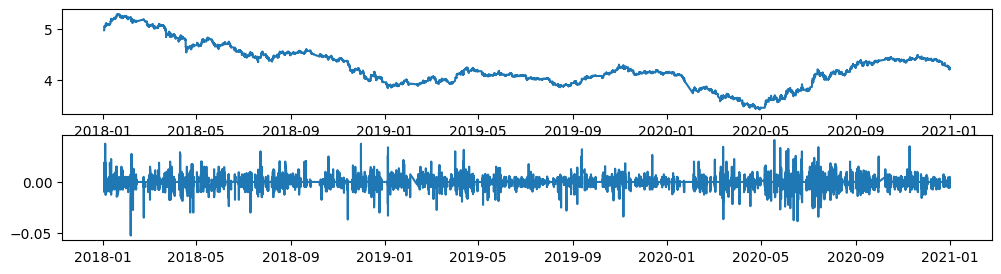

In [8]:
plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.plot(ytm_avg)
plt.subplot(2,1,2)
plt.plot(pnl)
plt.show()